<a href="https://colab.research.google.com/github/max1nehour/Python_projects/blob/main/LSTM_practice_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

# Import the training set
dataset_train = pd.read_csv('pm2.5_data_3_train1.csv')  # 讀取訓練集
print(dataset_train)
filt = (dataset_train['area'] == 'Banqiao')
training_set = dataset_train.loc[filt, ['PM2_5']].values
print(training_set)
training_set.shape

           Date       area  Long_range_trans  Vehicle_exhaust  Coal_fired  \
0    2017-01-01    Banqiao          0.456520         4.401043    0.502707   
1    2017-01-01     Chiayi          0.387843        22.131700    0.773481   
2    2017-01-01     Douliu          1.657679        11.170355    1.552080   
3    2017-01-01    Hualien          0.034066         3.683370    0.094480   
4    2017-01-01   Xiaogang          2.605544        19.554745    1.393970   
..          ...        ...               ...              ...         ...   
726  2018-12-22     Chiayi          0.629655        30.289835    0.962013   
727  2018-12-22     Douliu          2.762889         9.984987    0.862275   
728  2018-12-22    Hualien          0.080599         4.253326    0.162199   
729  2018-12-22   Xiaogang          4.069600        12.981454    0.530829   
730  2018-12-22  Zhongming          0.517477        12.574030    5.793047   

     Road_dust  Soil_dust  Industrial_processes  Agricultural_activities  \

(122, 1)

做 Normalization，將資料壓縮在 [0,1] 之間

In [230]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) #控制最大值最小值範圍
training_set_scaled = sc.fit_transform(training_set)#fit_transform: 先對partData作fit()的功能，找到該partData的整體統計特性之指標，如平均值、標準差、最大最小值等等(能依據不同目的套用這些指標在不同的轉換(即後面的transform()動作)上，再實行transform(partData)以對partData進行標準化
print(training_set_scaled.shape)
#training_set_scaled = training_set
print(training_set_scaled.shape)

(122, 1)
(122, 1)


準備進入訓練的資料格式：設定 Timestep 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。

In [231]:
X_train = []
y_train = []
for i in range(20, 122):  # 訓練集總數
    X_train.append(training_set_scaled[i-20:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

Reshape
因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]

In [232]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#搭建一個 LSTM

In [233]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

搭建 LSTM layer

units: 神經元的數目

第一層的 LSTM Layer 記得要設定input_shape參數

搭配使用dropout，這裡設為 0.2

由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [234]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [235]:
# Adding the output layer
regressor.add(Dense(units = 1))

#Compiling & Fitting LSTM model

optimizer: 選擇 Adam

loss: 使用 MSE

In [236]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(X_train.shape)
# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

(102, 20, 1)
Epoch 1/100
4/4 [==============================] - 9s 44ms/step - loss: 0.0490
Epoch 2/100
4/4 [==============================] - 0s 50ms/step - loss: 0.0243
Epoch 3/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0225
Epoch 4/100
4/4 [==============================] - 0s 51ms/step - loss: 0.0227
Epoch 5/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0221
Epoch 6/100
4/4 [==============================] - 0s 51ms/step - loss: 0.0207
Epoch 7/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0229
Epoch 8/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0205
Epoch 9/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0217
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0220
Epoch 11/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0210
Epoch 12/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0205
Epoch 13/100
4/4 [==================

# 進行預測

In [237]:
#取測試集中 2017 年的股票資料（真實）
dataset_test = pd.read_csv('pm2.5_data_3_test.csv')
print(dataset_test)
filt2 = (dataset_test['area'] == 'Banqiao')
real_pm25 = dataset_test.loc[filt2, ['PM2_5']].values
print(real_pm25.shape)
print(real_pm25)
#real_pm25 = dataset_test.loc[filt2, ['pm25']]
#real_pm25

           Date       area  Long_range_trans  Vehicle_exhaust  Coal_fired  \
0    2019-01-03    Banqiao          0.192979         1.609420    0.129014   
1    2019-01-03     Chiayi          0.299420        11.534817    0.461483   
2    2019-01-03     Douliu          1.092333         4.880216    0.489556   
3    2019-01-03    Hualien          0.012352         0.953386    0.069130   
4    2019-01-03   Xiaogang          2.489239         8.504630    0.347688   
..          ...        ...               ...              ...         ...   
361  2019-12-23     Chiayi          0.381544        15.153218    0.575682   
362  2019-12-23     Douliu          0.520352         8.169237    2.453606   
363  2019-12-23    Hualien          0.071570         2.015280    0.121488   
364  2019-12-23   Xiaogang          2.663056         9.696881    0.401567   
365  2019-12-23  Zhongming          0.164308         3.985862    3.010674   

     Road_dust  Soil_dust  Industrial_processes  Agricultural_activities  \

In [238]:
#取模型所預測的 2017 年股票資料（預測
dataset_total = pd.concat((dataset_train['PM2_5'], dataset_test['PM2_5']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 20:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(20,81): # timesteps一樣60； 80 = 20+61
    X_test.append(inputs[i- 20:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [239]:
#進行預測
predicted_pm25 = regressor.predict(X_test)
predicted_pm25 = sc.inverse_transform(predicted_pm25)  # to get the original scale

2/2 [==============================] - 2s 32ms/step


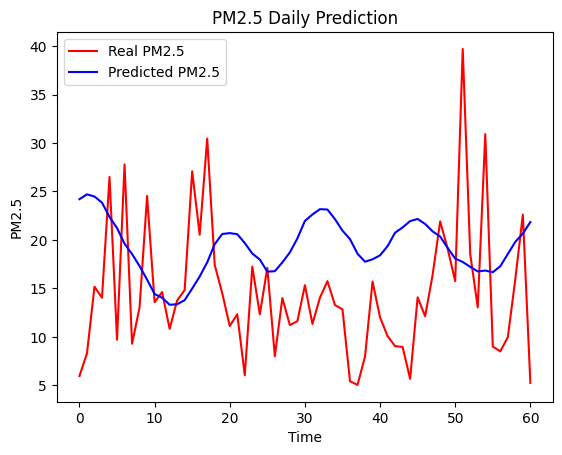

In [240]:
# 視覺化結果
plt.plot(real_pm25, color = 'red', label = 'Real PM2.5')  # 紅線表示真實股價
plt.plot(predicted_pm25, color = 'blue', label = 'Predicted PM2.5')  # 藍線表示預測股價
plt.title('PM2.5 Daily Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()